# NLP Project: Airline sentiment analysis


## **Context:**

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from 
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed 
by categorizing negative reasons (such as "late flight" or "rude service").

#### The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative or neutral. In this analysis, we will focus the positive/negative/neutral sentiment of the recommendation.



In [107]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# Loading data into pandas dataframe
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Tweets.csv")

In [110]:
data.info() #check data fields

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [111]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


## Typical EDA numbers such as means and quartiles for numeric variables do not matter much for text based sentiment analysis, however it is still useful to check Describe output. Here we can see that negativereason_confidence may have missing values as the count is less than 14640. However we are not interested in this column itself, so the missing values won't matter there. But it is useful to know. For features of interest, we shall chack null values separately later on

In [112]:
data.shape                                               # print shape of data.

(14640, 15)

In [113]:
data.head()                                              # Print first 5 rows of data.

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [114]:
# Only keeping airline sentiment and text columns from the data, as these are useful for our analysis.

data = data.loc[:14639, ['airline_sentiment', 'text']]

In [115]:
data.shape

(14640, 2)

In [116]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [117]:
data.tail()

,airline_sentiment,text
14635,positive,@AmericanAir thank you we got on a different flight to Chicago.
14636,negative,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc
14637,neutral,@AmericanAir Please bring American Airlines to #BlackBerry10
14638,negative,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"
14639,neutral,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?


In [118]:
data.isnull().sum(axis=0)                                # Check for NULL values.

airline_sentiment    0
text                 0
dtype: int64

## It is important to check for null values and treat them if necessary, as they can impact classification. In our case we have no null values

In [119]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated text column.)

data.head()                                 # Check first 5 rows of data

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


In [120]:
data["airline_sentiment"].value_counts() #check distribution of target class

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

#Majority seem to be negative reviews. However other classes are also present in good numbers

In [121]:
#convert target to integer
replaceStruct = {
                
                 "airline_sentiment":     {"negative": 1, "neutral": 2 ,"positive": 3 }
                 
                    }

In [122]:
data = data.replace(replaceStruct)
data.info() #confirm that the target is now integer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  int64 
 1   text               14640 non-null  object
dtypes: int64(1), object(1)
memory usage: 228.9+ KB


In [123]:
data["airline_sentiment"].value_counts() #confirm that the target distribution same after type change to integer

1    9178
2    3099
3    2363
Name: airline_sentiment, dtype: int64

### Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords - this has not been explicitely asked in the project task. There is a debate about whether stopwords should be removed or not for sentiment analysis. Advantage is it reduces dimensions but disadvantage is they may have relevant sentiment info. For correctness I am running this tasks with both stopwords removed and stopwords not removed. I shall comapre the scores and provide commentary
- Lemmatized data - preferring lemmatization over stemming as lemmatization is more accurate and given the data size is not that large, there are no performance implications

We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [124]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,3,@VirginAmerica plus you've added commercials to the experience... tacky.
2,2,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,1,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,1,@VirginAmerica and it's a really big bad thing about it


In [125]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,3,@VirginAmerica plus you have added commercials to the experience... tacky.
2,2,@VirginAmerica I did not today... Must mean I need to take another trip!
3,1,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,1,@VirginAmerica and it is a really big bad thing about it


In [126]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,3,@VirginAmerica plus you have added commercials to the experience... tacky.
2,2,@VirginAmerica I did not today... Must mean I need to take another trip!
3,1,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,1,@VirginAmerica and it is a really big bad thing about it


In [127]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

In [128]:
data.head()                                                                    # Look at how tokenized data looks.

,airline_sentiment,text
0,2,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,3,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,2,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,1,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,1,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


In [129]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))                              

In [130]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words): #with stopward removal
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

def normalize2(words): #without stopword removal
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    #words = remove_stopwords(words) 
    words = lemmatize_list(words)
    return ' '.join(words)

In [131]:
#create an object to record scores so we can compare in end
class scorerecord:
    def __init__(self, mode, score):
        self.mode = mode
        self.score = score

scorelist = []

In [132]:
#create another copy of data for running models without stopword removal
data2 = data.copy()


In [133]:
data['text'] = data.apply(lambda row: normalize(row['text']), axis=1) #pre-processed with stopwords removed
data.head() #check 5 rows after pre-processing

,airline_sentiment,text
0,2,virginamerica dhepburn say
1,3,virginamerica plus add commercials experience tacky
2,2,virginamerica not today must mean need take another trip
3,1,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,1,virginamerica really big bad thing


Notice how exclamation marks etc are gone and data is pure text

In [134]:
data2['text'] = data2.apply(lambda row: normalize2(row['text']), axis=1) #pre-processed with stopwords not removed 
data2.head() #check 5 rows after pre-processing, notice the difference between earlier set and this one, with words like 'what' not removed

,airline_sentiment,text
0,2,virginamerica what dhepburn say
1,3,virginamerica plus you have add commercials to the experience tacky
2,2,virginamerica i do not today must mean i need to take another trip
3,1,virginamerica it be really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,1,virginamerica and it be a really big bad thing about it


## Vectorization with countvector and TFID

Both the countvector (or bag of words) and TFID learn by calculating frequency of words. Countvector returns integers whereas TFID
returns floats. The main difference is that the countvector just goes by number of occurences without caring whether the word is "too common"
and present across many documents (because if that is the case it is not really a sentiment influencing word). In nutshell countvector
assumes each word to be independent in each document. TFID addresses this limitation by checking for occurences of the word in all documents
and normalizases the score using log function. The logarithmic function takes care of substantially reducing or even zero-ing weight of very
common words occuring everywhere. Normally we may expect more sophisticated TFID vectorization to give better accuracy 
but we cannot be sure of it and we must test the results.


In [135]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=2000)                # Keep only 2000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['text'])

data_features2 = vectorizer.fit_transform(data2['text'])
#print(data_features)


In [136]:
data_features = data_features.toarray()                        # Convert the data features to array.

In [137]:
data_features.shape

(14640, 2000)

In [138]:
data_features2 = data_features2.toarray()  #version with stopwords not removed
data_features2.shape

(14640, 2000)

In [139]:
labels = data['airline_sentiment']
#labels = labels.astype('int'), target variable is already int


In [140]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  int64 
 1   text               14640 non-null  object
dtypes: int64(1), object(1)
memory usage: 228.9+ KB


In [141]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_features2, labels, test_size=0.3, random_state=42)


In [142]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_test2, return_counts=True))

(array([1, 2, 3]), array([2814,  884,  694]))
(array([1, 2, 3]), array([2814,  884,  694]))


In [143]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42)

forest = forest.fit(X_train, y_train)

print(forest)

score = np.mean(cross_val_score(forest, data_features, labels, cv=10))
print(score) 
score1 = scorerecord("countvector with stopwords removed", score)
scorelist.append([score1.mode, score1.score])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7178961748633881


In [144]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[2505  223   86]
 [ 394  410   80]
 [ 172  111  411]]


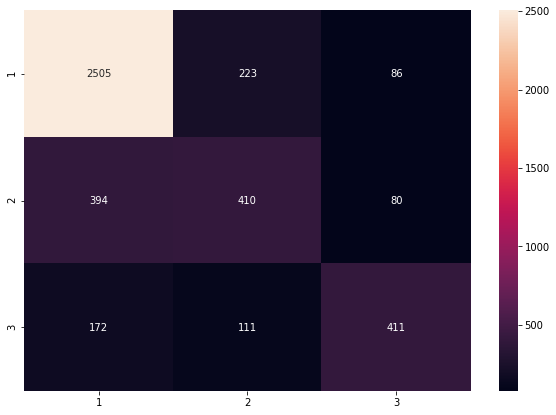

In [145]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

# CM is consistent with accuracy but note how class 2 (neutral) has been misclassfied with only 410 out of 884 predicted correctly. So accuracy is very poor if you only look at Neutral but since this class does not dominate the distribution, overall accurcy remains good

#Now run with stopwords not removed

In [146]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42)

forest = forest.fit(X_train2, y_train2)

print(forest)

score = np.mean(cross_val_score(forest, data_features2, labels, cv=10))
print(score)
score2 = scorerecord("countvector with stopwords not removed", score)
scorelist.append([score2.mode, score2.score])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.721379781420765


[[2611  143   60]
 [ 468  369   47]
 [ 257   93  344]]


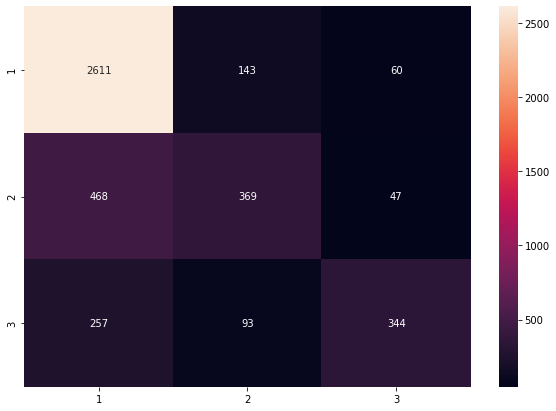

In [147]:
result = forest.predict(X_test2)
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test2, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Overall accuracy has improved but again class 2 is poorly predicted with only 369 out of 884 predicted correctly. Also class 3 (postive sentiment) accuracy is poor with only 344 out of 694 predicted correctly. But class 1 accuracy has improved significantly improving overall score

# Use TFID with stopwords removed and not removed

In [148]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
data_features = vectorizer.fit_transform(data['text'])
data_features2 = vectorizer.fit_transform(data2['text'])

#print(data_features)

In [149]:
data_features = data_features.toarray()

data_features.shape

(14640, 2000)

In [150]:
data_features2 = data_features2.toarray() #for stopwords not removed

data_features2.shape

(14640, 2000)

## We have to do train/test split again as we have changed the vectorizer

In [151]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data_features2, labels, test_size=0.3, random_state=42)

In [152]:
print(np.unique(y_test, return_counts=True))
print(np.unique(y_test2, return_counts=True))

(array([1, 2, 3]), array([2814,  884,  694]))
(array([1, 2, 3]), array([2814,  884,  694]))


In [153]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42)

forest = forest.fit(X_train, y_train)

print(forest)

score = np.mean(cross_val_score(forest, data_features, labels, cv=10))
print(score)
score3 = scorerecord("TFID with stopwords removed", score)
scorelist.append([score3.mode, score3.score])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7150956284153006


In [154]:
result = forest.predict(X_test)

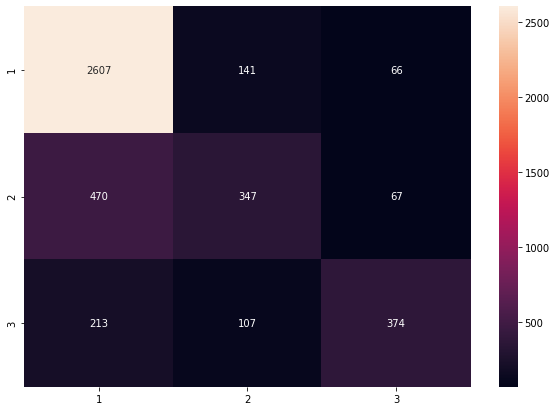

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Overall accuracy good but class 2 accuracy very poor with only 347 out of 884 predicted correctly

In [156]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=42)

forest = forest.fit(X_train2, y_train2) #for stopwords not removed

print(forest)

score = np.mean(cross_val_score(forest, data_features2, labels, cv=10))
print(score)
score4 = scorerecord("TFID with stopwords not removed", score)
scorelist.append([score4.mode, score4.score])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
0.7086065573770491


[[2660  113   41]
 [ 491  356   37]
 [ 299   97  298]]


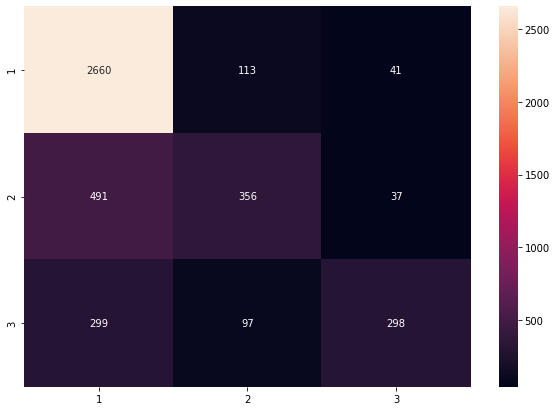

In [157]:
result = forest.predict(X_test2)
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test2, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

## Overall accuracy slightly decreased and both class 2 and class 3 accuracies are very poor

In [158]:
for i in range(0, len(scorelist)):
  print(scorelist[i])

['countvector with stopwords removed', 0.7178961748633881]
['countvector with stopwords not removed', 0.721379781420765]
['TFID with stopwords removed', 0.7150956284153006]
['TFID with stopwords not removed', 0.7086065573770491]


Summary:

- We used dataset which has reviews in text format and their sentiment score on the scale of 1 to 3.
- The goal was to build a model for text-classification.
- We Pre-processed the data using variuos techniques and libraries.
- The pre-precessed data is converted to numbers, so that we can feed the data in the model.
- After building the classification model, we predicted the result for the test data.
- After that we saw that using the above techniques, our model performed good in perspective of how the text classification models perform (over 70% accuracy is good)
- However, we saw that some of the classes can be badly represented. In almost every case we saw that accuracy was poor in predicting 'Neutral' sentiment and with stopwords not removed, accuracy of class 3 (postive sentiment) also went down. The models were fairly successful in predicting negative sentiment, which is the dominant class
- One more way to increase accuracy is to use different variations of Pre-processing techniques and try max features, other hyper parameters, using gridsearch etc. We have seen that removing or not removing stopwords is having some impact. We got the max accuracy with countvector and stopwords not removed. However this is very much dataset dependent and I would recommend running both countvector and tfid with both stopwords removed and not removed and check the scores. We cannot assume that any single technique here would always give best score.